In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [32]:
goods_types = pd.read_csv('./实验4GoodsTypes.csv', encoding='gbk')
goods_order = pd.read_csv('./实验4GoodsOrder.csv', encoding='gbk')

In [33]:
print(goods_types.info())
print('\n==========================================\n')
print(goods_order.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Goods   169 non-null    object
 1   Types   169 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43367 entries, 0 to 43366
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      43367 non-null  int64 
 1   Goods   43367 non-null  object
dtypes: int64(1), object(1)
memory usage: 677.7+ KB
None


In [34]:
print(goods_types.head())
print(goods_order.head())

   Goods Types
0     白饭    熟食
1     白酒  酒精饮料
2    白兰地  酒精饮料
3    白面包    西点
4  半成品面包    西点
   id  Goods
0   1  柑橘类水果
1   1   人造黄油
2   1    即食汤
3   1  半成品面包
4   2     咖啡


### 分析热销产品

#### 分类汇总

In [35]:
# 分类汇总
goods_types.groupby(by='Types').count()

,Goods
Types,
果蔬,14
熟食,9
百货,43
米粮调料,32
肉类,16
西点,21
酒精饮料,11
零食,8
非酒精饮料,11


In [98]:
# 排名前20的商品销量
goods_sales = goods_order.drop(columns=['id'])
goods_sales.insert(loc=1, column='count', value=1)
goods_sales = goods_sales.groupby(by='Goods').aggregate(np.sum)
top_20_sales = goods_sales.sort_values(by='count', ascending=False)[:20]

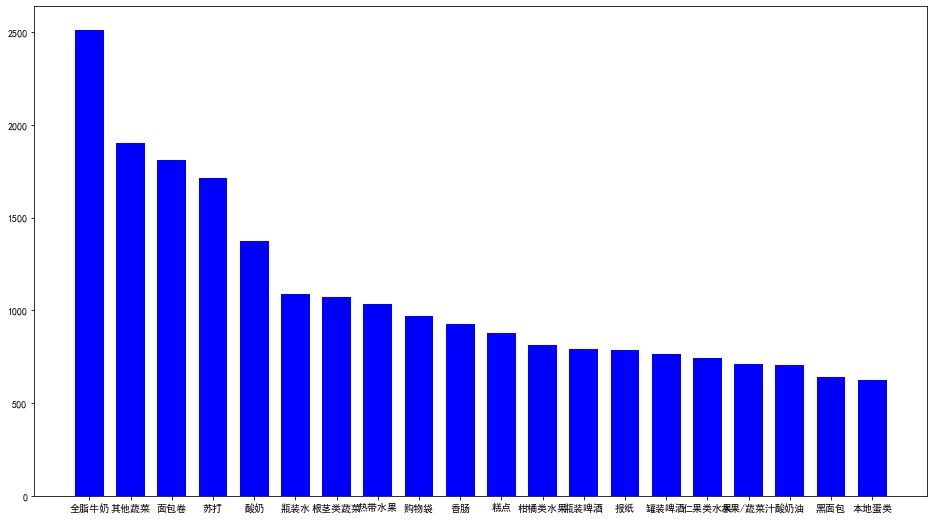

In [99]:
# 绘制条形图
plt.figure(figsize=(16, 9))
plt.bar(top_20_sales.index, top_20_sales['count'], color='b', width=0.7)
plt.autoscale()
plt.show()

In [100]:
print('排行前20的商品销量占比:', 
        top_20_sales['count'].sum() / goods_sales['count'].sum())


排行前20的商品销量占比: 0.5037932068162427


### 各类别商品的销量及其占比

In [101]:
goods_types

,Goods,Types
0,白饭,熟食
1,白酒,酒精饮料
2,白兰地,酒精饮料
3,白面包,西点
4,半成品面包,西点
...,...,...
164,有机香肠,肉类
165,鱼,肉类
166,浴室清洁剂,百货
167,长面包,西点


In [102]:
# 各商品销量
goods_sales

,count
Goods,
一般清洁剂,189
一般肉类,254
一般饮料,256
人造黄油,576
仁果类水果,744
...,...
马铃薯产品,28
鱼,29
鸡,422


In [152]:
# reset_index() 将index变为列
sales_by_type = pd.merge(left=goods_sales.reset_index(),
         right=goods_types, 
         how='inner')\
    .drop(columns=['Goods'])\
    .sort_values(by='count', ascending=False)

In [156]:
# 按照商品类别进行合并
sales_by_type = sales_by_type.groupby(by='Types')\
                             .aggregate(np.sum)\
                             .sort_values(by='count', ascending=False)
# # 计算百分比
sales_by_type['percentage'] = sales_by_type['count']  \
                                / sales_by_type['count'].sum()
sales_by_type = sales_by_type.drop(columns='count')
sales_by_type.to_csv('./GoodsTypesRate.csv', encoding='utf8')

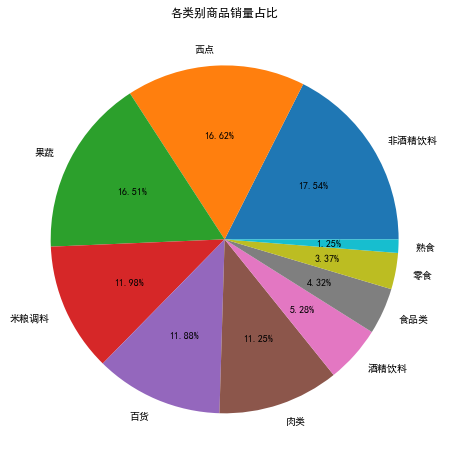

In [178]:
# 绘制饼图
plt.figure(figsize=(12, 8))
plt.pie(x=sales_by_type['percentage'], 
        autopct='%.2f%%',
        labels=sales_by_type.index
        )
plt.title('各类别商品销量占比')
plt.show()

### 非酒精饮料内部商品的销量及其占比

In [197]:
tmp = pd.merge(left=goods_sales.reset_index(),
               right=goods_types, 
               how='inner',
               )\
        .sort_values(by='count', ascending=False)

tmp = tmp.set_index('Goods')
tmp = tmp[tmp['Types'] == '非酒精饮料']
tmp['percentage'] =  tmp['count'] / tmp['count'].sum()
non_alcohol_sales = tmp.drop(columns=['count', 'Types'])
non_alcohol_sales.to_csv('非酒精饮料类别中各商品的销量占比.csv', encoding='utf8')

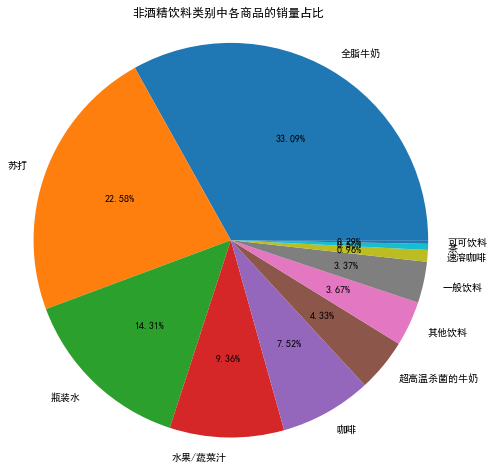

In [205]:
# 绘制饼图
plt.figure(figsize=(12, 8))
plt.pie(x=non_alcohol_sales['percentage'], 
        autopct='%.2f%%',
        labels=non_alcohol_sales.index,
        )
plt.title('非酒精饮料类别中各商品的销量占比')
plt.autoscale()
plt.show()

### 使用Apriori算法进行关联分析

In [228]:
goods_types
# 产生项集
item_sets = goods_order.groupby(by='id')['Goods']\
           .apply(lambda x: x.str.cat(sep=','))\
           .reset_index()\
           .drop(columns=['id'])

In [238]:
item_sets.values

array([['柑橘类水果,人造黄油,即食汤,半成品面包'],
       ['咖啡,热带水果,酸奶'],
       ['全脂牛奶'],
       ...,
       ['黄油,鸡,柑橘类水果,保鲜膜/袋,本地蛋类,冷冻甜点,其他蔬菜,面包卷,朗姆酒,酸奶'],
       ['瓶装啤酒,瓶装水,半成品面包,苏打'],
       ['鸡,其他蔬菜,购物袋,热带水果,醋']], dtype=object)

In [248]:
item_set_vector = list()
for item in item_sets.values:
    item_set_vector.append(item[0].split(','))
item_set_vector

[['柑橘类水果', '人造黄油', '即食汤', '半成品面包'],
 ['咖啡', '热带水果', '酸奶'],
 ['全脂牛奶'],
 ['奶油乳酪', '肉泥', '仁果类水果', '酸奶'],
 ['炼乳', '长面包', '其他蔬菜', '全脂牛奶'],
 ['腐蚀性清洁剂', '黄油', '白饭', '全脂牛奶', '酸奶'],
 ['面包卷'],
 ['瓶装啤酒', '开胃酒', '其他蔬菜', '面包卷', '超高温杀菌的牛奶'],
 ['盆栽'],
 ['谷物', '全脂牛奶'],
 ['瓶装水', '巧克力', '其他蔬菜', '热带水果', '白面包'],
 ['瓶装水', '黄油', '柑橘类水果', '凝乳', '碗碟', '面粉', '热带水果', '全脂牛奶', '酸奶'],
 ['牛肉'],
 ['冷冻热狗肠', '面包卷', '苏打'],
 ['鸡', '热带水果'],
 ['黄油', '水果/蔬菜汁', '报纸', '糖'],
 ['水果/蔬菜汁'],
 ['包装水果/蔬菜'],
 ['巧克力'],
 ['特制门锁'],
 ['其他蔬菜'],
 ['酪', '糕点'],
 ['全脂牛奶'],
 ['奶油乳酪', '一般清洁剂', '报纸', '融化奶酪', '热带水果'],
 ['浴室清洁剂',
  '糖果',
  '面粉',
  '冷冻甜点',
  '其他蔬菜',
  '面包卷',
  '根茎类蔬菜',
  '咸点心',
  '甜食',
  '热带水果',
  '威化饼'],
 ['瓶装水', '罐装啤酒'],
 ['酸奶'],
 ['巧克力', '面包卷', '香肠', '苏打'],
 ['其他蔬菜'],
 ['黑面包', '罐装啤酒', '水果/蔬菜汁', '报纸', '购物袋', '苏打'],
 ['一般饮料', '瓶装水', '特制门锁', '酸奶'],
 ['瓶装水', '汉堡肉', '卫生用品', '餐巾', '其他蔬菜', '面包卷', '香辛料'],
 ['一般饮料', '其他蔬菜', '根茎类蔬菜', '糖', '全脂牛奶'],
 ['腐蚀性清洁剂', '甜味剂', '莓果', '其他蔬菜', '猪肉', '苏打', '酸奶油', '全脂牛奶'],
 ['牛肉', '一般清洁剂', '葡萄'],
 ['糕点'

#### Apriori算法

In [ ]:
# -*- coding: utf-8 -*-
# Apriori algorithm

from numpy import *
 
def loadDataSet():
    return item_set_vector
    # return [['a', 'c', 'e'], ['b', 'd'], ['b', 'c'], ['a', 'b', 'c', 'd'], ['a', 'b'], ['b', 'c'], ['a', 'b'],
    #         ['a', 'b', 'c', 'e'], ['a', 'b', 'c'], ['a', 'c', 'e']]
 
def createC1(dataSet):
    C1 = []
    for transaction in dataSet:
        for item in transaction:
            if not [item] in C1:
                C1.append([item])
    C1.sort()
    # 映射为frozenset唯一性的，可使用其构造字典
    return list(map(frozenset, C1))     
    
# 从候选K项集到频繁K项集（支持度计算）
def scanD(D, Ck, minSupport):
    ssCnt = {}
    for tid in D:   # 遍历数据集
        for can in Ck:  # 遍历候选项
            if can.issubset(tid):  # 判断候选项中是否含数据集的各项
                if not can in ssCnt:
                    ssCnt[can] = 1  # 不含设为1
                else:
                    ssCnt[can] += 1  # 有则计数加1
    numItems = float(len(D))  # 数据集大小
    retList = []  # L1初始化
    supportData = {}  # 记录候选项中各个数据的支持度
    for key in ssCnt:
        support = ssCnt[key] / numItems  # 计算支持度
        if support >= minSupport:
            retList.insert(0, key)  # 满足条件加入L1中
            supportData[key] = support  
    return retList, supportData
 
def calSupport(D, Ck, min_support):
    dict_sup = {}
    for i in D:
        for j in Ck:
            if j.issubset(i):
                if not j in dict_sup:
                    dict_sup[j] = 1
                else:
                    dict_sup[j] += 1
    sumCount = float(len(D))
    supportData = {}
    relist = []
    for i in dict_sup:
        temp_sup = dict_sup[i] / sumCount
        if temp_sup >= min_support:
            relist.append(i)
# 此处可设置返回全部的支持度数据（或者频繁项集的支持度数据）
            supportData[i] = temp_sup
    return relist, supportData
 
# 改进剪枝算法
def aprioriGen(Lk, k):
    retList = []
    lenLk = len(Lk)
    for i in range(lenLk):
        for j in range(i + 1, lenLk):  # 两两组合遍历
            L1 = list(Lk[i])[:k - 2]
            L2 = list(Lk[j])[:k - 2]
            L1.sort()
            L2.sort()
            if L1 == L2:  # 前k-1项相等，则可相乘，这样可防止重复项出现
                # 进行剪枝（a1为k项集中的一个元素，b为它的所有k-1项子集）
                a = Lk[i] | Lk[j]  # a为frozenset()集合
                a1 = list(a)
                b = []
                # 遍历取出每一个元素，转换为set，依次从a1中剔除该元素，并加入到b中
                for q in range(len(a1)):
                    t = [a1[q]]
                    tt = frozenset(set(a1) - set(t))
                    b.append(tt)
                t = 0
                for w in b:
                    # 当b（即所有k-1项子集）都是Lk（频繁的）的子集，则保留，否则删除。
                    if w in Lk:
                        t += 1
                if t == len(b):
                    retList.append(b[0] | b[1])
    return retList

def apriori(dataSet, minSupport=0.2):
# 前3条语句是对计算查找单个元素中的频繁项集
    C1 = createC1(dataSet)
    D = list(map(set, dataSet))  # 使用list()转换为列表
    L1, supportData = calSupport(D, C1, minSupport)
    L = [L1]  # 加列表框，使得1项集为一个单独元素
    k = 2
    while (len(L[k - 2]) > 0):  # 是否还有候选集
        Ck = aprioriGen(L[k - 2], k)
        Lk, supK = scanD(D, Ck, minSupport)  # scan DB to get Lk
        supportData.update(supK)  # 把supk的键值对添加到supportData里
        L.append(Lk)  # L最后一个值为空集
        k += 1
    del L[-1]  # 删除最后一个空集
    return L, supportData  # L为频繁项集，为一个列表，1，2，3项集分别为一个元素

# 生成集合的所有子集
def getSubset(fromList, toList):
    for i in range(len(fromList)):
        t = [fromList[i]]
        tt = frozenset(set(fromList) - set(t))
        if not tt in toList:
            toList.append(tt)
            tt = list(tt)
            if len(tt) > 1:
                getSubset(tt, toList)
 
def calcConf(freqSet, H, supportData, ruleList, minConf=0.7):
    for conseq in H:  #遍历H中的所有项集并计算它们的可信度值
        conf = supportData[freqSet] / supportData[freqSet - conseq]  # 可信度计算，结合支持度数据
        # 提升度lift计算lift = p(a & b) / p(a)*p(b)
        lift = supportData[freqSet] / (supportData[conseq] * supportData[freqSet - conseq])

        if conf >= minConf and lift > 1:
            print("-".join(list(freqSet - conseq)), '-->', "-".join(list(conseq)), '支持度', round(supportData[freqSet], 6), '置信度：', round(conf, 6),
                  'lift值为：', round(lift, 6))
            ruleList.append((list(freqSet - conseq), list(conseq), supportData[freqSet],conf, lift))
 
# 生成规则
def gen_rule(L, supportData, minConf = 0.7):
    bigRuleList = []
    for i in range(1, len(L)):  # 从二项集开始计算
        for freqSet in L[i]:  # freqSet为所有的k项集
            # 求该三项集的所有非空子集，1项集，2项集，直到k-1项集，用H1表示，为list类型,里面为frozenset类型，
            H1 = list(freqSet)
            all_subset = []
            getSubset(H1, all_subset)  # 生成所有的子集
            calcConf(freqSet, all_subset, supportData, bigRuleList, minConf)
    return bigRuleList




In [334]:
from apyori import apriori
table = pd.DataFrame(columns=['item_set', 'confidence', 'lift'])

for item in apriori(item_set_vector):
    tmp_df = pd.DataFrame([[','.join(item[0]), round(item[1], ndigits=3), item[2][0].lift]], columns=['item_set', 'confidence', 'lift'])
    table = pd.concat([table, tmp_df], axis=0)

table = table.reset_index().drop(columns=['index'])
table 

,item_set,confidence,lift
0,全脂牛奶,0.256,1.0
1,其他蔬菜,0.193,1.0
2,根茎类蔬菜,0.109,1.0
3,热带水果,0.105,1.0
4,瓶装水,0.111,1.0
5,苏打,0.174,1.0
6,酸奶,0.14,1.0
7,面包卷,0.184,1.0
